<center><h1>ARIMA TRAINING</h1><center>

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [42]:
# Load dataset and convert year
df = pd.read_csv("05_genres_median_audio_features.csv")
df['track_album_release_date'] = pd.to_datetime(df['track_album_release_date'], format='%Y')
df['year'] = df['track_album_release_date'].dt.year

genres = ['pop', 'hip-hop', 'latin', 'electronic']
pdq_grid = [(0,0,1), (0,1,1), (1,0,1), (1,1,0), (1,1,1), (2,1,0), (2,1,1)]

best_pdq_by_genre = {}

for genre in genres:
    print(f"\n=== Testing PDQ for: {genre.upper()} ===")
    df_genre = df[df['playlist_genre'] == genre].copy()
    ts = df_genre.groupby('year')['median_track_popularity'].median()
    ts.index = pd.date_range(start=f'{ts.index.min()}', periods=len(ts), freq='YS')

    if ts.nunique() == 1:
        print(f"⚠️ Skipping {genre}, constant series")
        continue

    best_aic = float('inf')
    best_order = None

    for order in pdq_grid:
        try:
            model = ARIMA(ts, order=order)
            result = model.fit()
            if result.aic < best_aic:
                best_aic = result.aic
                best_order = order
        except:
            continue

    best_pdq_by_genre[genre] = best_order
    print(f"✅ Best ARIMA order for {genre}: {best_order}")



=== Testing PDQ for: POP ===
✅ Best ARIMA order for pop: (0, 1, 1)

=== Testing PDQ for: HIP-HOP ===


c:\Users\jonaz\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


✅ Best ARIMA order for hip-hop: (0, 1, 1)

=== Testing PDQ for: LATIN ===
✅ Best ARIMA order for latin: (0, 1, 1)

=== Testing PDQ for: ELECTRONIC ===
✅ Best ARIMA order for electronic: (0, 1, 1)


In [43]:
# Set manual (p, d, q) values based on prior tuning or testing
manual_pdq = {
    'pop': (1, 2, 1),
    'hip-hop': (1, 1, 1),
    'latin': (1, 1, 1),
    'electronic': (1, 1, 1),
}

def forecast_arima_by_genre_manual(df, genres, pdq_dict):
    for genre in genres:
        print(f"\n=== ARIMA Forecast for: {genre.upper()} ===")

        # Filter and aggregate by year
        df_genre = df[df['playlist_genre'] == genre].copy()
        df_genre['track_album_release_date'] = pd.to_datetime(df_genre['track_album_release_date'], format='%Y')
        df_genre['year'] = df_genre['track_album_release_date'].dt.year
        ts = df_genre.groupby('year')['median_track_popularity'].median()

        # Use consistent datetime index for forecasting/plotting
        ts.index = pd.date_range(start=f'{ts.index.min()}', periods=len(ts), freq='YE')

        if ts.nunique() == 1:
            print(f"⚠️ Skipping {genre} because the time series is constant ({ts.iloc[0]})")
            continue

        # Stationarity check
        adf_result = adfuller(ts)
        print(f"ADF p-value (raw series): {adf_result[1]:.4f}")
        if adf_result[1] > 0.05:
            print(" → Non-stationary, differencing will be handled by ARIMA.")
            ts_diff = ts.diff().dropna()
            adf_diff_result = adfuller(ts_diff)
            print(f"ADF p-value (after 1st differencing): {adf_diff_result[1]:.4f}")
            if adf_diff_result[1] > 0.05:
                print(" → Still non-stationary after 1st differencing. Trying 2nd differencing...")
                ts_diff2 = ts_diff.diff().dropna()
                adf_diff2_result = adfuller(ts_diff2)
                print(f"ADF p-value (after 2nd differencing): {adf_diff2_result[1]:.4f}")
                if adf_diff2_result[1] > 0.05:
                    print(" ⚠️ Still non-stationary after 2nd differencing.")
                else:
                    print(" ✅ Stationary after 2nd differencing.")
            else:
                print(" ✅ Stationary after 1st differencing.")
        else:
            print(" ✅ Series is already stationary.")

        # ARIMA model
        order = pdq_dict.get(genre, (1, 1, 1))
        print(f"Using manual ARIMA order: {order}")

        try:
            model = ARIMA(ts, order=order)
            model_fit = model.fit()
        except Exception as e:
            print(f"❌ Failed to fit ARIMA for {genre}: {e}")
            continue

        # Forecast with confidence intervals
        try:
            forecast_steps = 5
            forecast_obj = model_fit.get_forecast(steps=forecast_steps)
            forecast = forecast_obj.predicted_mean
            conf_int = forecast_obj.conf_int()
            forecast_years = pd.date_range(start=ts.index[-1] + pd.DateOffset(years=1), periods=forecast_steps, freq='YE')
        except Exception as e:
            print(f"⚠️ Forecasting 5 years failed: {e}")
            print("→ Trying 2-year forecast...")
            try:
                forecast_steps = 2
                forecast_obj = model_fit.get_forecast(steps=forecast_steps)
                forecast = forecast_obj.predicted_mean
                conf_int = forecast_obj.conf_int()
                forecast_years = pd.date_range(start=ts.index[-1] + pd.DateOffset(years=1), periods=forecast_steps, freq='YE')
            except Exception as e2:
                print(f"❌ Forecasting 2 years also failed: {e2}")
                continue

        print(f"Forecast ({forecast_years[0].year}–{forecast_years[-1].year}):")
        print(pd.Series(forecast, index=forecast_years))

        # Evaluate model on last 2 years
        mae, rmse = None, None
        if len(ts) >= 4:
            y_true = ts[-2:]
            y_pred = model_fit.predict(start=len(ts)-2, end=len(ts)-1)
            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            print(f"MAE: {mae:.2f} | RMSE: {rmse:.2f}")

        # Plot
        plt.figure(figsize=(10, 5))
        plt.plot(ts.index, ts.values, marker='o', color='tab:blue', label='Actual')
        plt.plot(forecast_years, forecast, linestyle='--', marker='o', color='tab:orange', label='Forecast')
        plt.fill_between(
            forecast_years,
            conf_int.iloc[:, 0],
            conf_int.iloc[:, 1],
            color='orange',
            alpha=0.2,
            label='95% Confidence Interval'
        )
        plt.axvline(x=ts.index[-1], color='gray', linestyle=':', linewidth=1)

        # Annotate title with MAE/RMSE
        title_metrics = f" (MAE: {mae:.2f}, RMSE: {rmse:.2f})" if mae is not None and rmse is not None else ""
        plt.title(f"ARIMA Forecast for '{genre.capitalize()}'{title_metrics}", fontsize=14)
        plt.xlabel("Year", fontsize=12)
        plt.ylabel("Median Track Popularity", fontsize=12)
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()



=== ARIMA Forecast for: POP ===
ADF p-value (raw series): 0.1484
 → Non-stationary, differencing will be handled by ARIMA.
ADF p-value (after 1st differencing): 0.0783
 → Still non-stationary after 1st differencing. Trying 2nd differencing...
ADF p-value (after 2nd differencing): 0.0000
 ✅ Stationary after 2nd differencing.
Using manual ARIMA order: (1, 2, 1)
Forecast (2025–2029):
2025-12-31    85.044617
2026-12-31    85.749497
2027-12-31    86.306868
2028-12-31    86.897193
2029-12-31    87.480157
Freq: YE-DEC, Name: predicted_mean, dtype: float64
MAE: 2.28 | RMSE: 2.34


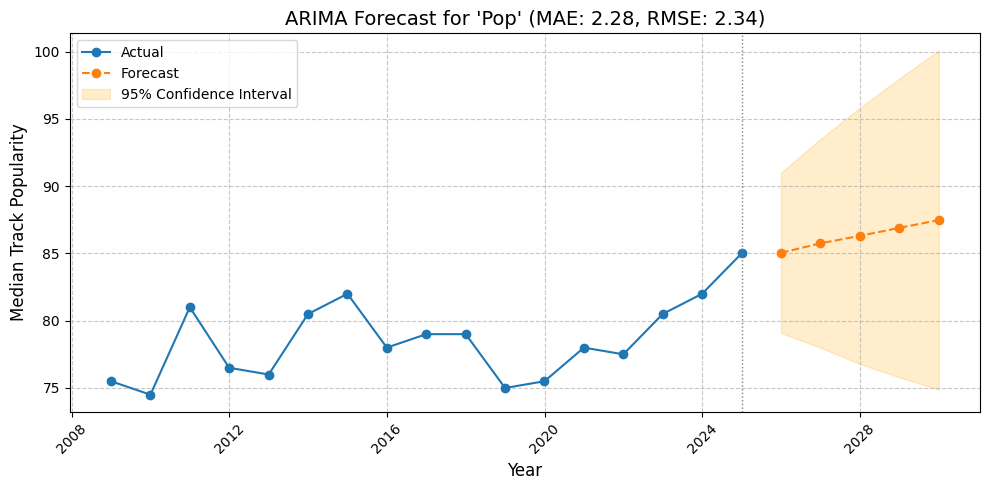


=== ARIMA Forecast for: HIP-HOP ===
ADF p-value (raw series): 0.0000
 ✅ Series is already stationary.
Using manual ARIMA order: (1, 1, 1)
Forecast (2024–2028):
2024-12-31    71.764995
2025-12-31    72.049664
2026-12-31    71.984048
2027-12-31    71.999172
2028-12-31    71.995686
Freq: YE-DEC, Name: predicted_mean, dtype: float64
MAE: 1.34 | RMSE: 1.36


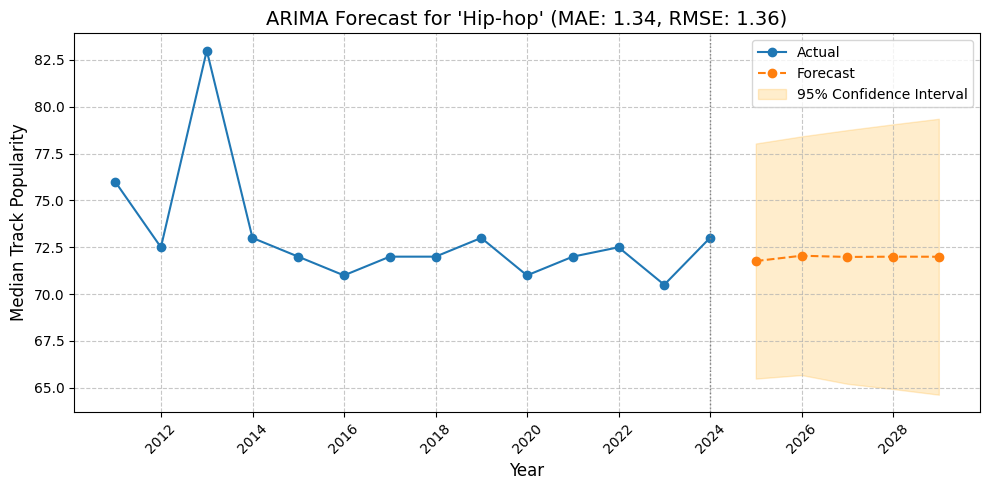


=== ARIMA Forecast for: LATIN ===
ADF p-value (raw series): 0.3505
 → Non-stationary, differencing will be handled by ARIMA.
ADF p-value (after 1st differencing): 0.0073
 ✅ Stationary after 1st differencing.
Using manual ARIMA order: (1, 1, 1)
Forecast (2025–2029):
2025-12-31    74.916803
2026-12-31    73.527263
2027-12-31    73.054394
2028-12-31    72.893473
2029-12-31    72.838710
Freq: YE-DEC, Name: predicted_mean, dtype: float64
MAE: 4.00 | RMSE: 4.51


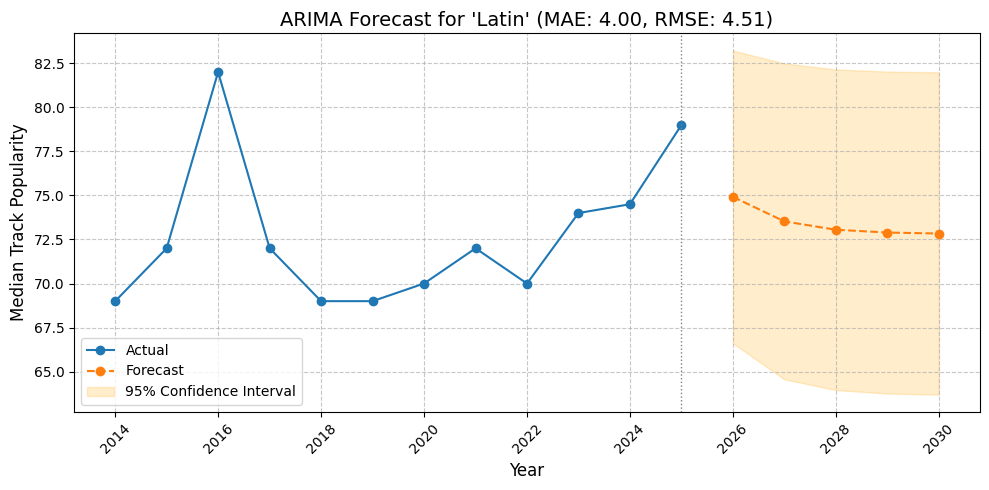


=== ARIMA Forecast for: ELECTRONIC ===
ADF p-value (raw series): 0.2126
 → Non-stationary, differencing will be handled by ARIMA.
ADF p-value (after 1st differencing): 0.0001
 ✅ Stationary after 1st differencing.
Using manual ARIMA order: (1, 1, 1)
Forecast (2024–2028):
2024-12-31    71.572641
2025-12-31    72.124965
2026-12-31    72.318946
2027-12-31    72.387073
2028-12-31    72.411000
Freq: YE-DEC, Name: predicted_mean, dtype: float64
MAE: 2.07 | RMSE: 2.09


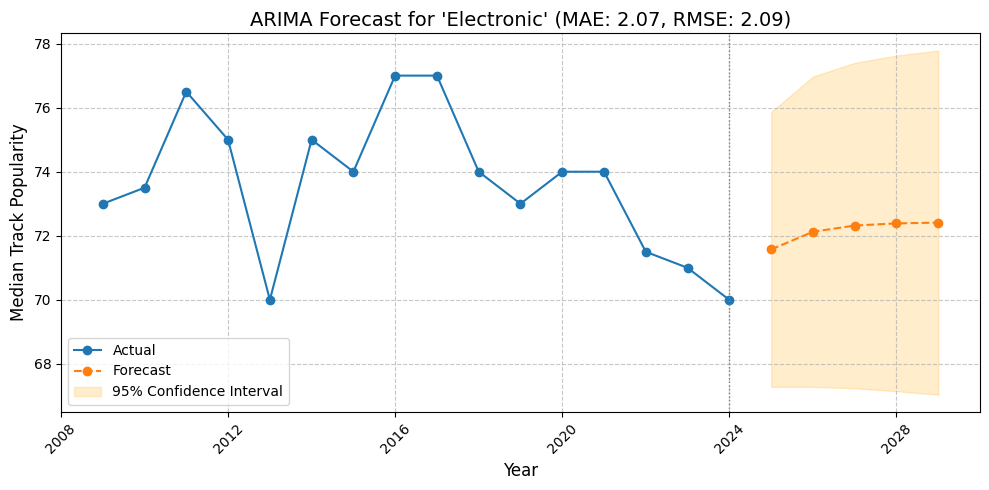

In [44]:
df = pd.read_csv("05_genres_median_audio_features.csv")
genres = ['pop', 'hip-hop', 'latin', 'electronic']

forecast_arima_by_genre_manual(df, genres, manual_pdq)
